#### CODE FOR THE ANALYSIS OF THE RESULTS OF LEGALGPT GRADING

In [2]:
# Imports

import pandas as pd
from scipy.stats import mannwhitneyu, wilcoxon
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
nlp = spacy.load("en_core_web_sm")

### GRADE ANALYSIS

In [3]:
# An example results file is provided, to show the results file format. Grades are converted to numerals in the results file:
data = pd.read_csv('results_example.csv')

In [4]:
final_grade_gpt = data[data['author'] == 'gpt-4']['grade']
final_grade_student = data[data['author'] == 'student']['grade']
final_grade_accordion = data[(data['author'] == 'gpt-4') & (data['type'] == 'accordion')]['grade']
final_grade_recursive = data[(data['author'] == 'gpt-4') & (data['type'] == 'recursive')]['grade']
median = data[data['author'] == 'gpt-4']['median']
argStruct = data[data['author'] == 'gpt-4']['argStruct']
knowUnder = data[data['author'] == 'gpt-4']['knowUnder']
critAnaly= data[data['author'] == 'gpt-4']['critAnaly']

In [5]:
print(mannwhitneyu(x=final_grade_gpt, y=final_grade_student))
print(mannwhitneyu(x=final_grade_accordion, y=final_grade_recursive))
print(wilcoxon(argStruct, median, alternative='greater'))

MannwhitneyuResult(statistic=32.0, pvalue=1.0)
MannwhitneyuResult(statistic=8.0, pvalue=1.0)
WilcoxonResult(statistic=36.0, pvalue=0.00390625)


### PLOTS

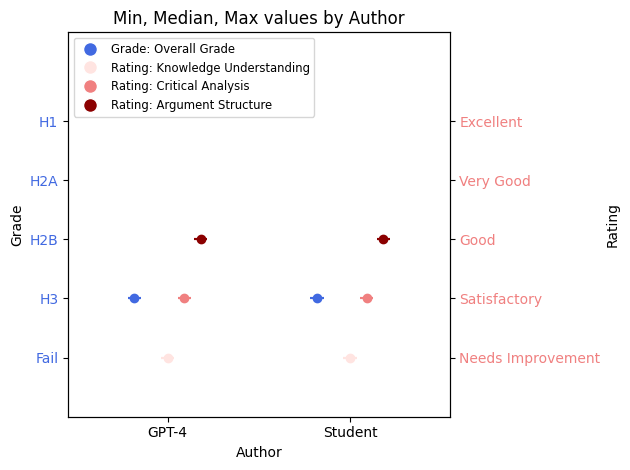

In [6]:
fields = {
    'grade' : ['Grade: Overall Grade','royalblue'],
    'knowUnder' : ['Rating: Knowledge Understanding','mistyrose'],
    'critAnaly' : ['Rating: Critical Analysis','lightcoral'],
    'argStruct' : ['Rating: Argument Structure','darkred']
}

aggregations = ['min', 'median', 'max']
stats = data.groupby('author').agg({key: aggregations for key in fields})
fig, ax = plt.subplots()
intra_author_step = 0.5  # gap between measures for the same author
inter_author_gap = 3     # gap between different authors
grade_gap = 1            # gap between 'grade' and subsequent 'mark' values
positions = {}
for idx, author in enumerate(stats.index):
    base = idx * (3 * intra_author_step + grade_gap + inter_author_gap)
    field_keys = iter(fields)
    positions[author] = {
        next(field_keys): base,
        next(field_keys): base + grade_gap,
        next(field_keys): base + grade_gap + 1*intra_author_step,
        next(field_keys): base + grade_gap + 2*intra_author_step
    }

for author in stats.index:
    for field in fields:
        pos = positions[author][field]
        y_median = stats[field]['median'][author]
        y_min = stats[field]['min'][author]
        y_max = stats[field]['max'][author]

        ax.plot(pos, y_median, 'o', color=fields[field][1])
        ax.hlines(y=[y_min, y_max], xmin=pos-0.2, xmax=pos+0.2, color=fields[field][1])
        ax.vlines(x=pos, ymin=y_min, ymax=y_max, color=fields[field][1])

legend_handles = [Line2D([0], [0], marker='o', color='w', label=fields[field][0],
                         markersize=10, markerfacecolor=fields[field][1]) for field in fields]
ax.legend(handles=legend_handles, loc="upper left", fontsize='small')
ax.set_title('Min, Median, Max values by Author')

ax.set_xticks([(positions[author][next(iter(fields))] + positions[author][next(reversed(fields))]) / 2 for author in stats.index])
ax.set_xticklabels(['GPT-4','Student'])
ax.set_xlabel('Author')
leftmost_x = positions[stats.index[0]][next(iter(fields))]
rightmost_x = positions[stats.index[-1]][next(reversed(fields))]
ax.set_xlim(leftmost_x - 2, rightmost_x + 2)

# Set y axis, labels and positions:
grade_to_string = {
    1: 'Fail',
    2: 'H3',
    3: 'H2B',
    4: 'H2A',
    5: 'H1'
}
ax.set_yticks(list(grade_to_string.keys()))
ax.set_yticklabels(list(grade_to_string.values()))
ax.set_ylabel('Grade')
ax.tick_params(axis='y', labelcolor='royalblue')
y_min = min(grade_to_string.keys())
y_max = max(grade_to_string.keys())
ax.set_ylim(y_min - 1, y_max + 1.5)

# Set twin y-axis:
rating_to_string = {
    1: 'Needs Improvement',
    2: 'Satisfactory',
    3: 'Good',
    4: 'Very Good',
    5: 'Excellent'
}
ax2 = ax.twinx()
ax2.set_yticks(list(rating_to_string.keys()))
ax2.set_yticklabels(list(rating_to_string.values()))
ax2.set_ylim(ax.get_ylim()) # sychronize y-axis limits with existing y axis.
ax2.set_ylabel('Rating')
ax2.tick_params(axis='y', labelcolor='lightcoral')

plt.tight_layout()
plt.show()


#### SENTIMENT ANALYSIS

In [7]:
sid_obj = SentimentIntensityAnalyzer()

def get_polarity(text):
    doc = nlp(text)
    polarities = []
    for sent in doc.sents:
        polarities.append(sid_obj.polarity_scores(sent.text)['compound'])
    if len(polarities) > 0:
        return sum(polarities) / len(polarities)
    else:
        return 0

data['polarity'] = data['comment'].apply(get_polarity)

C:\Users\DC\AppData\Local\Temp\ipykernel_5764\1333179773.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(categories))


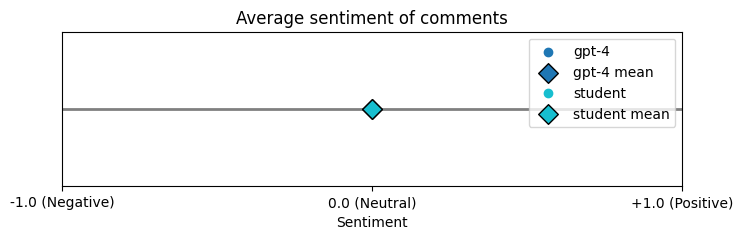

In [9]:
categories = data['author'].unique()
colors = plt.cm.get_cmap('tab10', len(categories))

fig, ax = plt.subplots(figsize=(8, 2))
y = [0] * len(data)
y_value = 0

# Plot each category
for i, category in enumerate(categories):
    category_data = data[data['author'] == category]
    ax.scatter(category_data['polarity'], [y_value]*len(category_data), label=category, color=colors(i))
    mean_polarity = category_data['polarity'].mean()
    ax.scatter(mean_polarity, y_value, color=colors(i), edgecolors='black', zorder=5, s=100, marker='D', label=f'{category} mean')

ax.yaxis.set_visible(False)
ax.set_xlim(-1, 1)
ax.legend()
plt.axhline(0, color='grey', lw=2, zorder=-1)
ax.set_xticks([-1, 0, 1])
ax.set_xticklabels(['-1.0 (Negative)', '0.0 (Neutral)', '+1.0 (Positive)'])

plt.xlabel('Sentiment')
plt.title('Average sentiment of comments')

plt.show()